In [1]:
import sys
sys.path.insert(0, '../../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

Use perwell analyses to calculate errors, and whole plate to calculate errors. Not clear how error progopgation /should/look. 

In [32]:
data_dir = ''
growth_exp = glob.glob(f'{data_dir}*growth')
growth_dfs = []
for _, d in enumerate(growth_exp):
#    if int(d.split('_')[0]) != 20190220:
    if glob.glob(f'{d}/output/delta_glucose/gp_output_stats.csv') != []:
        growth_df = pd.read_csv(glob.glob(f'{d}/output/delta_glucose/gp_output_stats.csv')[0]).drop(columns = 'Unnamed: 0')
        growth_df['date'] = d.split('_')[0]
        growth_df['temp_C'] = d.split('_')[2][0:2]
        growth_dfs.append(growth_df)
growth_df = pd.concat(growth_dfs)
growth_df['carbon'] = 'glucose'
growth_df['operator'] = 'O2'
growth_df.to_csv('compiled_growth_summary.csv', index=False)

In [33]:
growth_df = pd.read_csv(f'./compiled_growth_summary.csv')

In [34]:
growth_df.head()

,parameter,value,date,temp_C,carbon,operator
0,max df,0.007305,20190228,32,glucose,O2
1,max df std,0.000037,20190228,32,glucose,O2
2,max df stderr,0.000004,20190228,32,glucose,O2
3,time of max df,589.756667,20190228,32,glucose,O2
4,time of max df std,16.195737,20190228,32,glucose,O2


In [35]:
# select the first derivative and standard deviation parameters
growth_rate_df = growth_df[
    (growth_df['parameter'] == 'max df') | (growth_df['parameter'] == 'max df std')].copy().reset_index(drop=True)
# rename
growth_rate_df.loc[growth_rate_df['parameter'] == 'max df','parameter'] = 'growth_rate'
growth_rate_df.loc[growth_rate_df['parameter'] == 'max df std','parameter'] = 'growth_rate_std'

In [36]:
# reshape
wide = growth_rate_df.pivot(index = 'date', columns='parameter', values='value').reset_index()
long = growth_rate_df[['date','temp_C','carbon','operator']].drop_duplicates()
stats_df = pd.merge(long,wide, how='left', on='date').sort_values('date')

In [37]:
# calculate doubling times and standard deviations from first derivative
stats_df['doub_time_minutes'] = np.log(2)/stats_df['growth_rate']
stats_df['doub_time_std'] = np.log(2)*stats_df['growth_rate_std']/(stats_df['growth_rate'])**2
stats_df.sort_values('temp_C')

,date,temp_C,carbon,operator,growth_rate,growth_rate_std,doub_time_minutes,doub_time_std
6,20190220,27,glucose,O2,0.004321,0.000020,160.430490,0.734827
9,20190304,27,glucose,O2,0.004235,0.000010,163.686660,0.394459
4,20190313,27,glucose,O2,0.004151,0.000052,166.974434,2.099748
10,20190212,32,glucose,O2,0.007482,0.000077,92.639579,0.958316
0,20190228,32,glucose,O2,0.007305,0.000037,94.892130,0.479809
13,20190315,32,glucose,O2,0.007646,0.000065,90.651950,0.768991
17,20190121,37,glucose,O2,0.006780,0.000134,102.236240,2.024233
16,20190124,37,glucose,O2,0.010452,0.000064,66.314476,0.404687
20,20190125,37,glucose,O2,0.010611,0.000079,65.321156,0.488255
5,20190128,37,glucose,O2,0.010639,0.000090,65.149415,0.550909


In [26]:
import matplotlib.ticker as mticker

In [27]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

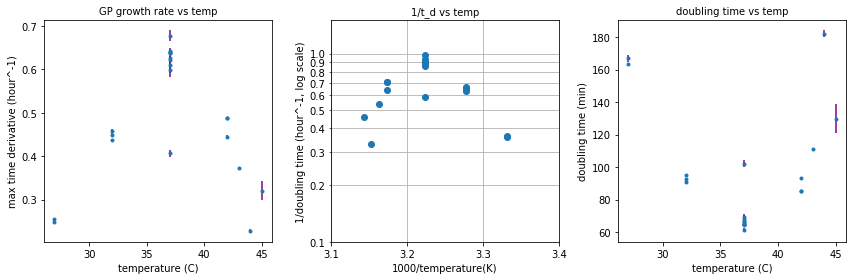

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title('GP growth rate vs temp', fontsize = 10)
ax[0].errorbar(stats_df['temp_C'], 60*stats_df['growth_rate'], yerr = 60*stats_df['growth_rate_std'],
              fmt = '.', ecolor = 'purple')
ax[0].set_xlabel('temperature (C)')
ax[0].set_ylabel('max time derivative (hour^-1)')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax[1].set_title('1/t_d vs temp', fontsize = 10)
ax[1].semilogy(1000/(stats_df['temp_C']+273.15), 60/stats_df['doub_time_minutes'], 'o')
ax[1].grid(True, which="both")
ax[1].set_yticks(np.arange(0.1,1.1,0.1), True)
ax[1].set_xticks(np.arange(3.1,3.5,0.1))
ax[1].set_ylim(0.1, 1.5)
ax[1].set_yticks([], False)
ax[1].yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].set_xlabel('1000/temperature(K)')
ax[1].set_ylabel('1/doubling time (hour^-1, log scale)')

ax[2].set_title('doubling time vs temp', fontsize=10)
ax[2].errorbar(stats_df['temp_C'], stats_df['doub_time_minutes'], yerr = stats_df['doub_time_std'],
               fmt = '.', ecolor = 'purple')
ax[2].set_xlabel('temperature (C)')
ax[2].set_ylabel('doubling time (min)')
ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.tight_layout()
#plt.savefig(f'delta_glucose_growth_rate_vs_temperature.png')

ValueError: x and y must have same first dimension, but have shapes (21,) and (0,)

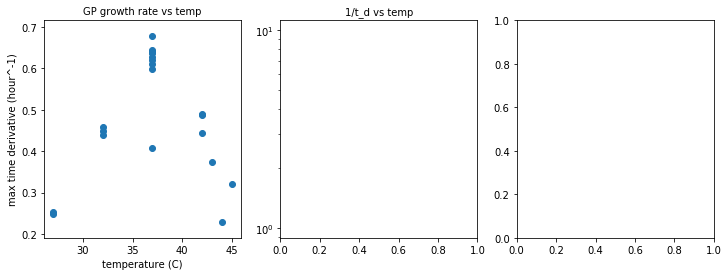

In [30]:
#Trash?

# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# ax[0].set_title('GP growth rate vs temp', fontsize = 10)
# ax[0].scatter(growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['temp_C'], 
#             60*growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['value'])
# ax[0].set_xlabel('temperature (C)')
# ax[0].set_ylabel('max time derivative (hour^-1)')
# ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# ax[1].set_title('1/t_d vs temp', fontsize = 10)
# ax[1].semilogy(1000/(growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['temp_C']+273.15), 
#             60/growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['value'], 'o')
# ax[1].grid(True, which="both")
# ax[1].set_yticks(np.arange(0.1,1.1,0.1), True)
# ax[1].set_xticks(np.arange(3.1,3.5,0.1))
# ax[1].set_ylim(0.1, 1.5)
# ax[1].set_yticks([], False)
# ax[1].yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax[1].set_xlabel('1000/temperature(K)')
# ax[1].set_ylabel('1/doubling time (hour^-1, log scale)')

# ax[2].set_title('doubling time vs temp', fontsize=10)
# ax[2].errorbar(growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['temp_C'], 
#             growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['value'], yerr = )
# ax[2].set_xlabel('temperature (C)')
# ax[2].set_ylabel('doubling time (min)')
# ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# fig.tight_layout()
#plt.savefig(f'delta_glucose_growth_rate_vs_temperature.png')

just in case

    def plotdoubtime(self, errorfac= 1, xlabel= 'time', ylabel= False, figtitle= False):
        '''
        Plots the results of the fit.

        Arguments
        --
        char: the type of fit to plot - 'f' or 'df' or 'ddf'
        errorfac: sets the size of the errorbars to be errorfac times the standard deviation
        ylabel: the y-axis label
        figtitle: the title of the figure
        '''
        x= getattr(self, 'df')
        xv= getattr(self, 'df' + 'var')
        dt= np.log(2)/x
        dtv= xv*(np.log(2)**2/(x**4))
        plt.plot(self.t, dt, 'b')
        plt.fill_between(self.t, dt-errorfac*np.sqrt(tdv), dt+errorfac*np.sqrt(tdv), facecolor= 'blue', alpha= 0.2)
        if ylabel:
            plt.ylabel(ylabel)
        else:
            plt.ylabel('dt')
        plt.xlabel(xlabel)
        if figtitle: plt.title(figtitle)